In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.learning_curve import validation_curve
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error
from sklearn.cluster import KMeans
import statsmodels.api as sm
import math
from scipy import stats
from scipy.stats import boxcox
from scipy.special import boxcox1p


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


# Load dataframe and add/clean columns

In [4]:
df = pd.read_csv('nfl_betting_df.csv', index_col = 0)

In [5]:
df['exp_win_difference'] = df.home_exp_win_pct- df.away_exp_win_pct
df['schedule_date']=df['schedule_date'].apply(pd.to_datetime)
df = df[df.schedule_season > 1978]

df['total_ppg'] = (df.h_ppg + df.a_ppg)
df['total_points_against'] = (df.h_papg + df.a_papg)
df['last_four_difference'] = (df.home_win_pct_last_4 - df.away_win_pct_last_4)

df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']]=df[['weather_temperature', 'weather_wind_mph', 'weather_humidity']].fillna(value=np.round(df.mean(),3))
df[['over_under_line']]=df[['over_under_line']].fillna(value=(np.round(df.mean()*2)/2))

df['over_under_result'] = np.where(df['over_under_result']=='under', 0, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='over', 1, df.over_under_result)
df['over_under_result'] = np.where(df['over_under_result']=='push', 2, df.over_under_result)

df['dome'] = np.where(df['weather_detail']=='DOME', 1, 0)

df = df.fillna(value = 0)

df.index = range(0, len(df))

In [6]:
reg_df = df[(df.schedule_week > 1) & (df.schedule_week < 19) & (df.schedule_season>2001)]
week5_df = df[(df.schedule_week > 4) & (df.schedule_week < 17) & (df.schedule_season>2001)]

# SPlit games into clusters


In [7]:
cluster_df = pd.read_csv('cluster_df.csv',index_col=0)

good_o_bad_d = cluster_df[cluster_df.cluster==2]
good_o_good_d = cluster_df[cluster_df.cluster==3]
bad_o_bad_d = cluster_df[cluster_df.cluster==1]
bad_o_good_d = cluster_df[cluster_df.cluster==0]

# Regression Formulas

In [8]:
def poly_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x,y)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)
    
#     #conditional to plot points in diff color depending on game outcome
#     if str(y) == str(reg_df.over_under_line):
#         y1 = y[week5_df['over_under_result']==1]
#         y2 = y[week5_df['over_under_result']==0]
#         y3 = y[week5_df['over_under_result']==2]
#         x1 = x[week5_df['over_under_result']==1]
#         x2 = x[week5_df['over_under_result']==0]
#         x3 = x[week5_df['over_under_result']==2]
#         plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
#         plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
#         plt.scatter(x3, y3, s = s, alpha = .4, color = 'yellow', label = 'Push')
#     else:
#         y1 = y[week5_df['favorite_covered']==1]
#         y2 = y[week5_df['favorite_covered']==0]
#         y3 = y[week5_df['favorite_covered']==2]
#         x1 = x[week5_df['favorite_covered']==1]
#         x2 = x[week5_df['favorite_covered']==0]
#         x3 = x[week5_df['favorite_covered']==2]
#         plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
#         plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
#         plt.scatter(x3, y3, s = s, alpha = .4, color = 'yellow', label = 'Push')
        
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')


In [9]:
def log_linear_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(x, np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']==1]
        y2 = y[reg_df['over_under_result']==0]
        x1 = x[reg_df['over_under_result']==1]
        x2 = x[reg_df['over_under_result']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

In [10]:
def log_log_regression(x, y, degree_range, xlim_min, xlim_max, ylim_min, ylim_max, alpha = .75,s = 5,width = 2.5):
    #create figure and set size and axis lims
    plt.figure(figsize = (10,10))
    plt.ylim(ylim_min, ylim_max)
    plt.xlim(xlim_min,xlim_max)
    
    #split inputs into training and test sets
    split = train_test_split(np.log(x+1), np.log(np.abs(y)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    x = X_train
    y = y_train
    plt.scatter(x, y, s = s, alpha = alpha)

    #conditional to plot points in diff color depending on game outcome
    if str(y) == str(reg_df.over_under_line):
        y1 = y[reg_df['over_under_result']==1]
        y2 = y[reg_df['over_under_result']==0]
        x1 = x[reg_df['over_under_result']==1]
        x2 = x[reg_df['over_under_result']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green', label = 'Over')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label = 'Under')
    else:
        y1 = y[reg_df['favorite_covered']==1]
        y2 = y[reg_df['favorite_covered']==0]
        x1 = x[reg_df['favorite_covered']==1]
        x2 = x[reg_df['favorite_covered']==0]
        plt.scatter(x1, y1, s = s, alpha = alpha, color = 'green',label = 'Covered')
        plt.scatter(x2, y2, s = s, alpha = .4, color = 'purple', label ='No Cover')
    
    for degree in degree_range:
        poly_model = make_pipeline(PolynomialFeatures(degree),
                               LinearRegression())
        poly_model.fit(x[:, np.newaxis], y)
        xfit = np.linspace(xlim_min,xlim_max, 10000)
        yfit = poly_model.predict(xfit[:, np.newaxis])
        plt.plot(xfit, yfit, label = 'degree={}'.format(degree),linewidth=width)
    plt.legend(loc = 'best')

# Regression Evaluations

In [11]:
def rmse_check(predictions, targets):

    differences = predictions - targets                       #the DIFFERENCEs.

    differences_squared = differences ** 2                    #the SQUAREs of ^

    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^

    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val                                           #get the ^

In [12]:
def regression_evaluation(target, X_list):
    split = train_test_split(X_list, target,random_state=69)
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
     
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted
    
    plt.scatter(y_predicted,residuals)
    check = round(rmse_check(y_predicted, y_actual) - rmse)
    print(est2.summary())
    plt.scatter(y_predicted,residuals)
    plt.show()
    sns.distplot(residuals)
    print(est2.params)
    print('RMSE=' + str(rmse) + ', check =' + str(check))

In [13]:
def log_log_regression_evaluation(target, X_list):
    split = train_test_split((np.log(np.abs(X_list)+1)), np.log(np.abs(target)+1))
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

In [14]:
def log_linear_regression_evaluation(target,X_list):
    split = train_test_split(X_list, np.log(np.abs(target)+1))## log-linear eval
    X_train, X_test, y_train, y_test = split[0], split[1], split[2],split[3]
    X = X_train
    target = y_train
    
    X2 = sm.add_constant(X)
    est = sm.OLS(target, X2)
    est2 = est.fit()
    
    y_predicted = est2.fittedvalues
    y_actual = target
    
    log_rmse = math.sqrt(mean_squared_log_error(y_actual, y_predicted))
    residuals = y_actual-y_predicted

    #plt.scatter(y_predicted,residuals)
    print(est2.summary())
    sns.distplot(residuals)
    print('Log RMSE=' + str(log_rmse))

## BoxCox Transformation for Over Under Line

In [15]:
yt,max_lambda =boxcox(good_o_bad_d.over_under_line)
yt,max_lambda
print(min(yt),max(yt))

17.50268868316203 28.846602338944933


# Variable 1 -Total Points Against

In [16]:
xt1,x1_lam=boxcox(good_o_bad_d.total_points_against)
xt1,x1_lam
print(min(xt1),max(xt1))

21690.823975626146 693084.5048025713


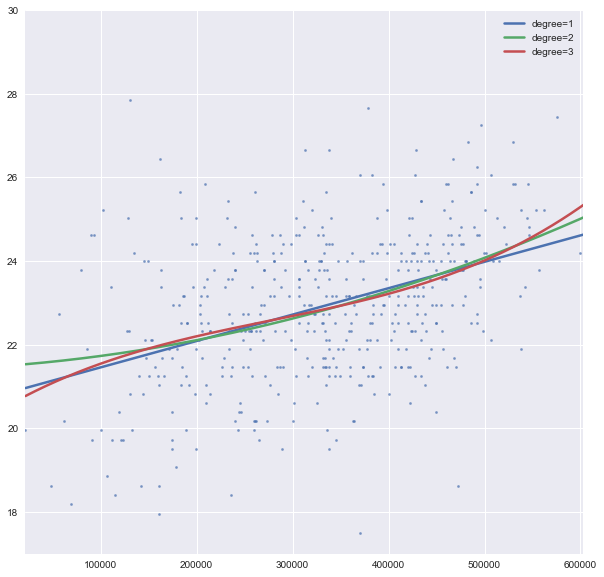

In [17]:
poly_regression(xt1, yt,[1,2,3], 21690,603084, 17,30)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     123.5
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           1.11e-25
Time:                        13:59:03   Log-Likelihood:                -915.31
No. Observations:                 480   AIC:                             1835.
Df Residuals:                     478   BIC:                             1843.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.6720      0.139    155.616      0.0

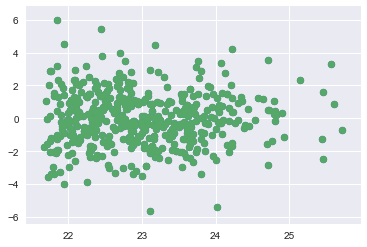

[2.16720085e+01 1.04998453e-11]
RMSE=1.6289989437003802, check =0.0


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


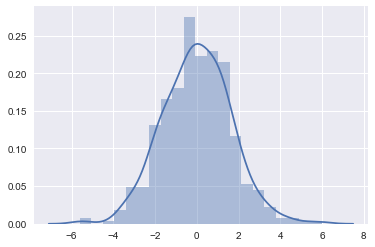

In [18]:
regression_evaluation(yt,xt1**2)

# Variable 2 - Total PPG

In [19]:
xt2,x2_lam=boxcox(good_o_bad_d.total_ppg)
xt2,x2_lam
print(min(xt2),max(xt2))

0.23088126277501594 0.23088127634498215


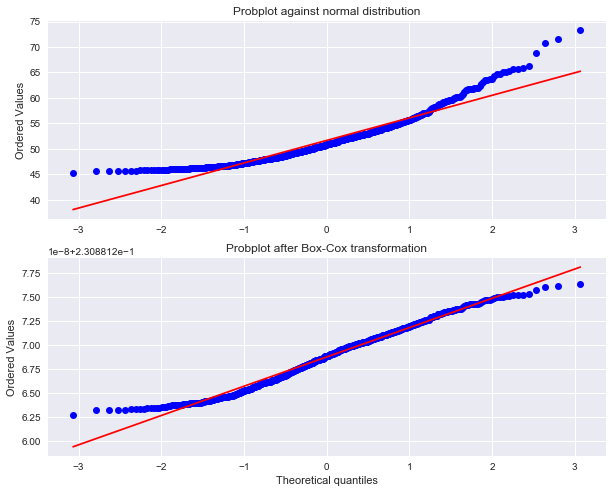

In [20]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(211)
x = good_o_bad_d.total_ppg
prob = stats.probplot(x, dist=stats.norm, plot=ax1)
ax1.set_xlabel('')
ax1.set_title('Probplot against normal distribution')

ax2 = fig.add_subplot(212)
xtest, _ = stats.boxcox(x)
prob = stats.probplot(xt2, dist=stats.norm, plot=ax2)
ax2.set_title('Probplot after Box-Cox transformation')
plt.show()

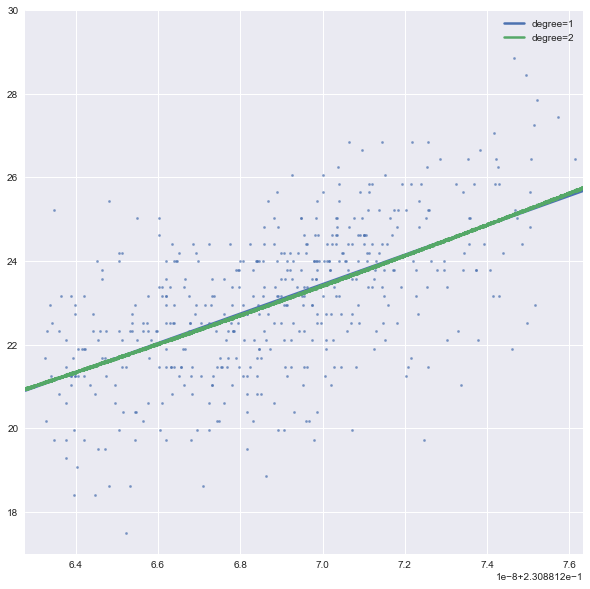

In [21]:
poly_regression(xt2,yt,[1,2],.23088126277501594,0.23088127634498215,17,30)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     256.5
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           1.57e-46
Time:                        13:59:05   Log-Likelihood:                -867.36
No. Observations:                 480   AIC:                             1739.
Df Residuals:                     478   BIC:                             1747.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -8.139e+07   5.08e+06    -16.017      0.0

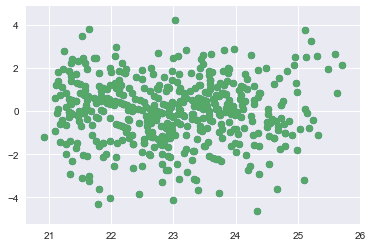

[-8.13944634e+07  3.52538285e+08]

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "



RMSE=1.4741227137922739, check =0.0


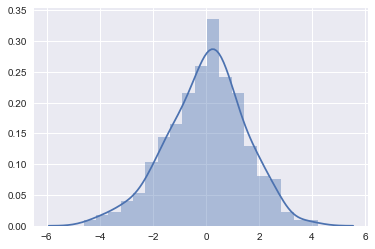

In [22]:
regression_evaluation(yt,xt2)

# Variable 3 - Weather Temperature

In [23]:
xt3,x3_lam=boxcox(good_o_bad_d.weather_temperature)
xt3,x3_lam
print(min(xt3),max(xt3))

18.668689318633803 450.17917536004757


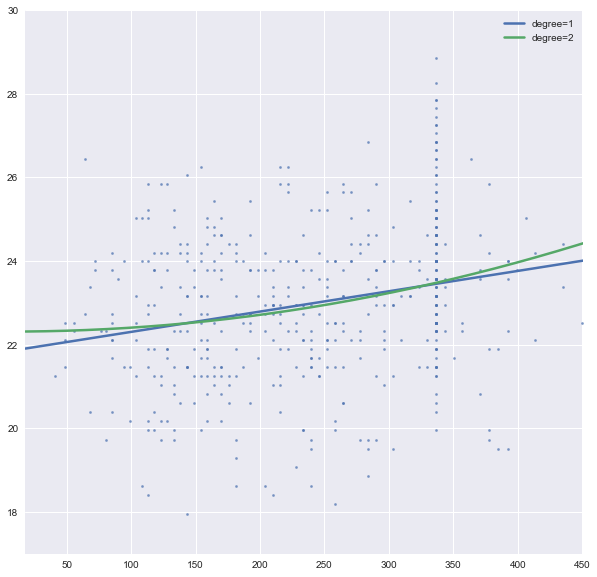

In [24]:
poly_regression(xt3,yt,[1,2],18,451,17,30)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     32.95
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           1.68e-08
Time:                        13:59:07   Log-Likelihood:                -954.47
No. Observations:                 480   AIC:                             1913.
Df Residuals:                     478   BIC:                             1921.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.2562      0.150    148.659      0.0

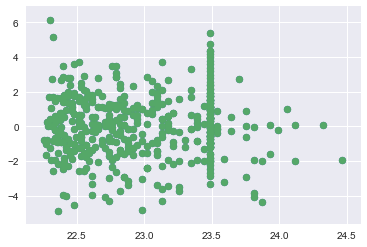

[2.22562315e+01 1.08959240e-05]
RMSE=1.7674650769537559, check =0.0


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


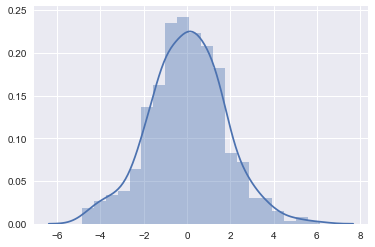

In [25]:
regression_evaluation(yt,xt3**2)

# Variable 4 - Weather Wind mph

In [26]:
xt4,x4_lam=boxcox(good_o_bad_d.weather_wind_mph+1)
xt4,x4_lam
print(min(xt4),max(xt4))

0.0 6.997479005838197


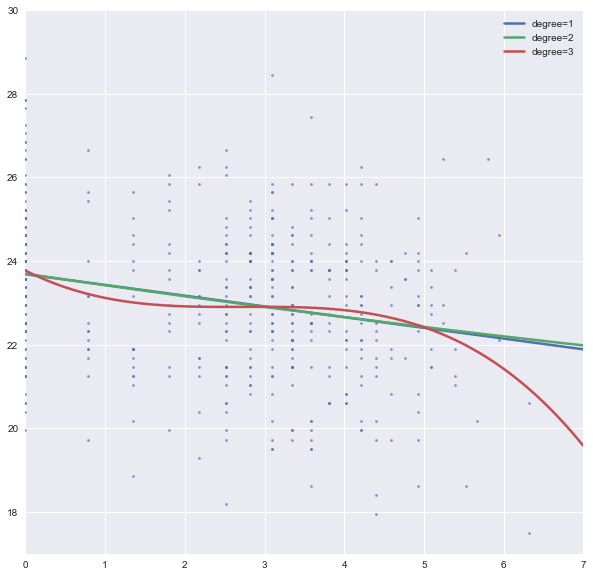

In [27]:
poly_regression(xt4,yt,[1,2,3],0,7,17,30)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     47.97
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           1.40e-11
Time:                        13:59:08   Log-Likelihood:                -947.52
No. Observations:                 480   AIC:                             1899.
Df Residuals:                     478   BIC:                             1907.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.7583      0.138    172.417      0.0

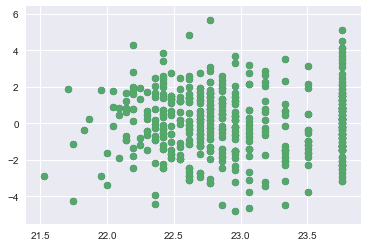

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[23.75825087 -0.31853881]
RMSE=1.7420429908780486, check =0.0


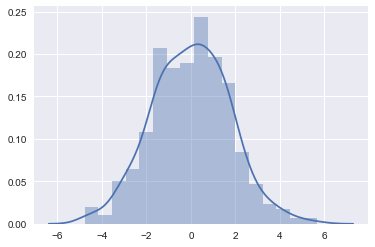

In [28]:
regression_evaluation(yt,xt4)

# Variable 5 - Weather Humidity

In [29]:
xt5,x5_lam=boxcox(good_o_bad_d.weather_humidity)
xt5,x5_lam
print(min(xt5),max(xt5))

74.58407742942293 3952.757089064835


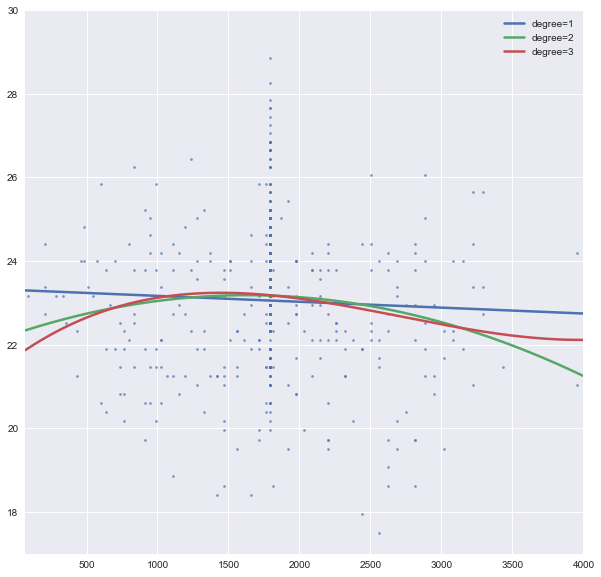

In [30]:
poly_regression(xt5,yt,[1,2,3],70,4000,17,30)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     6.324
Date:                Mon, 13 Aug 2018   Prob (F-statistic):             0.0122
Time:                        13:59:10   Log-Likelihood:                -967.32
No. Observations:                 480   AIC:                             1939.
Df Residuals:                     478   BIC:                             1947.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.6104      0.264     89.353      0.0

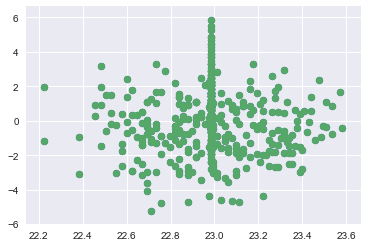

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


[ 2.36104051e+01 -3.50428932e-04]
RMSE=1.8154029678198904, check =0.0


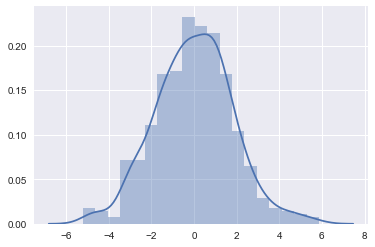

In [31]:
regression_evaluation(yt,xt5)

# Regression of over under - Good O Bad D

In [32]:
yt,max_lambda =boxcox(good_o_bad_d.over_under_line)
xt1,x1_lam=boxcox(good_o_bad_d.total_points_against)
xt2,x2_lam=boxcox(good_o_bad_d.total_ppg)
xt3,x3_lam=boxcox(good_o_bad_d.weather_temperature)
xt4,x4_lam=boxcox(good_o_bad_d.weather_wind_mph+1)
xt5,x5_lam=boxcox(good_o_bad_d.weather_humidity)

gobd_df = pd.DataFrame([xt1,xt2,xt3,xt4,xt5]).T
gobd_df.columns=['Total Points Against','Total PPG','Temp','Wind MPH','Humidity']
gobd_df.head()
len(gobd_df)

640

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     101.2
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           1.82e-72
Time:                        13:59:11   Log-Likelihood:                -796.17
No. Observations:                 480   AIC:                             1604.
Df Residuals:                     474   BIC:                             1629.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -6.728e+07 

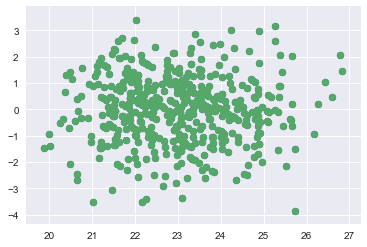

const                  -6.727926e+07
Total Points Against    4.979979e-06
Total PPG               2.914021e+08
Temp                    1.129285e-03
Wind MPH               -2.255602e-01
Humidity               -1.511881e-04
dtype: float64
RMSE=1.2709285488575621, check =0.0


/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


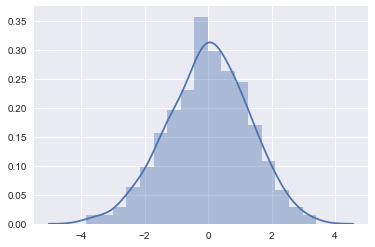

In [33]:
regression_evaluation(yt,gobd_df)

# Good O Good D

In [34]:
cluster_name = good_o_good_d

yt,max_lambda =boxcox(cluster_name.over_under_line)
xt1,x1_lam=boxcox(cluster_name.total_points_against)
xt2,x2_lam=boxcox(cluster_name.total_ppg)
xt3,x3_lam=boxcox(cluster_name.weather_temperature)
xt4,x4_lam=boxcox(cluster_name.weather_wind_mph+1)
xt5,x5_lam=boxcox(cluster_name.weather_humidity)

gogd_df = pd.DataFrame([xt1,xt2,xt3,xt4]).T
gogd_df.columns=['Total Points Against','Total PPG','Temp','Wind MPH']
gogd_df.head()
len(gogd_df)

regression_evaluation(yt,gogd_df)

ValueError: Data must be positive.

# bad O bad D

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     186.7
Date:                Mon, 13 Aug 2018   Prob (F-statistic):          4.03e-106
Time:                        13:59:14   Log-Likelihood:                -789.10
No. Observations:                 648   AIC:                             1588.
Df Residuals:                     643   BIC:                             1611.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   14.0937 

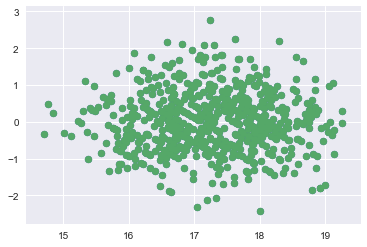

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


const                   1.409371e+01
Total Points Against    4.455859e-07
Total PPG               2.866647e-06
Temp                    2.335357e-03
Wind MPH               -9.971634e-02
dtype: float64
RMSE=0.8177558647986315, check =0.0


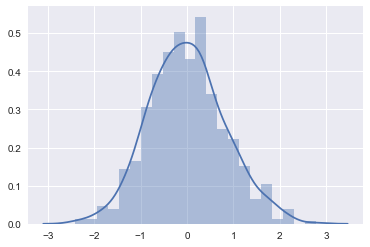

In [35]:
cluster_name = bad_o_bad_d

yt,max_lambda =boxcox(cluster_name.over_under_line)
xt1,x1_lam=boxcox(cluster_name.total_points_against)
xt2,x2_lam=boxcox(cluster_name.total_ppg)
xt3,x3_lam=boxcox(cluster_name.weather_temperature+1)
xt4,x4_lam=boxcox(cluster_name.weather_wind_mph+1)
xt5,x5_lam=boxcox(cluster_name.weather_humidity)

bobd_df = pd.DataFrame([xt1,xt2,xt3,xt4]).T
bobd_df.columns=['Total Points Against','Total PPG','Temp','Wind MPH']
bobd_df.head()

regression_evaluation(yt,bobd_df)

# Bad O Good D

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     121.8
Date:                Mon, 13 Aug 2018   Prob (F-statistic):           2.26e-87
Time:                        13:59:15   Log-Likelihood:                -1545.4
No. Observations:                 572   AIC:                             3103.
Df Residuals:                     566   BIC:                             3129.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -4.898e+07 

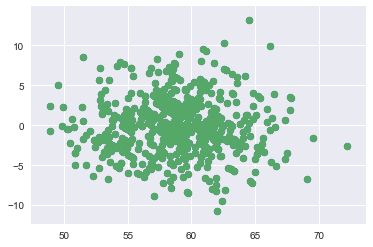

const                  -4.897930e+07
Total Points Against    2.019177e+08
Total PPG               7.057965e-05
Temp                    1.226379e-03
Wind MPH               -4.173836e-01
Humidity                2.344983e-04
dtype: float64
RMSE=3.6069397555048934, check =0.0

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


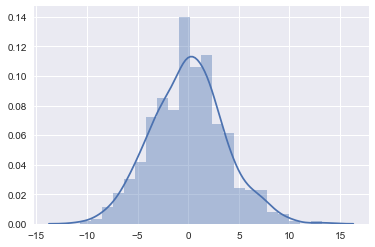

In [36]:
cluster_name = bad_o_good_d

yt,max_lambda =boxcox(cluster_name.over_under_line)
xt1,x1_lam=boxcox(cluster_name.total_points_against)
xt2,x2_lam=boxcox(cluster_name.total_ppg)
xt3,x3_lam=boxcox(cluster_name.weather_temperature+1)
xt4,x4_lam=boxcox(cluster_name.weather_wind_mph+1)
xt5,x5_lam=boxcox(cluster_name.weather_humidity)

bogd_df = pd.DataFrame([xt1,xt2,xt3,xt4,xt5]).T
bogd_df.columns=['Total Points Against','Total PPG','Temp','Wind MPH','Humidity']
bogd_df.head()

regression_evaluation(yt,bogd_df)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     954.1
Date:                Mon, 13 Aug 2018   Prob (F-statistic):               0.00
Time:                        13:59:17   Log-Likelihood:                -923.50
No. Observations:                2140   AIC:                             1859.
Df Residuals:                    2134   BIC:                             1893.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    4.0126 

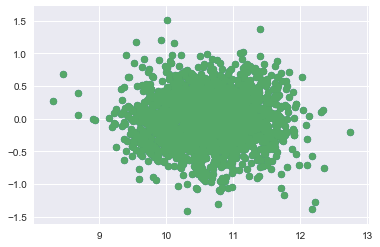

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


const                   4.012576
Total Points Against    0.067759
Total PPG               0.370374
Temp                    0.000211
Wind MPH               -0.056027
Humidity               -0.000080
dtype: float64
RMSE=0.3725461586589096, check =0.0


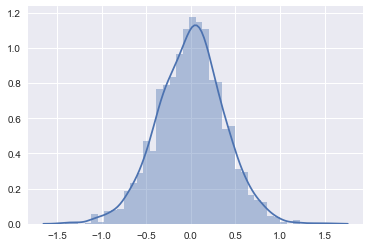

In [37]:
cluster_name = week5_df

yt,max_lambda =boxcox(cluster_name.over_under_line)
xt1,x1_lam=boxcox(cluster_name.total_points_against)
xt2,x2_lam=boxcox(cluster_name.total_ppg)
xt3,x3_lam=boxcox(cluster_name.weather_temperature+1)
xt4,x4_lam=boxcox(cluster_name.weather_wind_mph+1)
xt5,x5_lam=boxcox(cluster_name.weather_humidity)

bogd_df = pd.DataFrame([xt1,xt2,xt3,xt4,xt5]).T
bogd_df.columns=['Total Points Against','Total PPG','Temp','Wind MPH','Humidity']
bogd_df.head()

regression_evaluation(yt,bogd_df)

In [38]:
bogd_p = bad_o_good_d.pivot_table(index='over_under_line', columns='over_under_result',
                    aggfunc={'over_under_result':len}, fill_value = 0)

In [39]:
bogd_p['row_total'] = 0
rows = []
for index, row in bogd_p.iterrows():
    row.row_total = sum(row)
    rows.append(row)

In [40]:
ou_covered = bogd_p.over_under_result[1]
ou_no_cover = bogd_p.over_under_result[0]
ou_push = bogd_p.over_under_result[2]

In [41]:
lines = sorted(set(reg_df.over_under_line))
# x_lines = np.array([spread for spread in lines if spread > 33 and spread < 56])

In [42]:
y_over = [ou_covered[value]/bogd_p['row_total'][value] for value in lines if value in list(bad_o_good_d.over_under_line)]
y_under = [ou_no_cover[value]/bogd_p['row_total'][value] for value in lines if value in list(bad_o_good_d.over_under_line)]
y_neither = [ou_push[value]/bogd_p['row_total'][value] for value in lines if value in list(bad_o_good_d.over_under_line)]

In [43]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=lines,
    y=y_over,
    name='Over'
)
trace2 = go.Bar(
    x=lines,
    y=y_under,
    name='Under'
)

trace3 = go.Bar(
    x=lines,
    y=y_neither,
    name='Push'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group', title = 'Bad Offense Good Defense'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [44]:
bobd_p = bad_o_bad_d.pivot_table(index='over_under_line', columns='over_under_result',
                    aggfunc={'over_under_result':len}, fill_value = 0)

In [45]:
bobd_p['row_total'] = 0
rows = []
for index, row in bobd_p.iterrows():
    row.row_total = sum(row)
    rows.append(row)

In [46]:
ou_covered = bobd_p.over_under_result[1]
ou_no_cover = bobd_p.over_under_result[0]
ou_push = bobd_p.over_under_result[2]

In [47]:
lines = sorted(set(reg_df.over_under_line))
# x_lines = np.array([spread for spread in lines if spread > 33 and spread < 56])

In [48]:
y_over = [ou_covered[value]/bobd_p['row_total'][value] for value in lines if value in list(bad_o_bad_d.over_under_line)]
y_under = [ou_no_cover[value]/bobd_p['row_total'][value] for value in lines if value in list(bad_o_bad_d.over_under_line)]
y_neither = [ou_push[value]/bobd_p['row_total'][value] for value in lines if value in list(bad_o_bad_d.over_under_line)]

In [49]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=lines,
    y=y_over,
    name='Over'
)
trace2 = go.Bar(
    x=lines,
    y=y_under,
    name='Under'
)

trace3 = go.Bar(
    x=lines,
    y=y_neither,
    name='Push'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group', title = 'Bad Offense Bad Defense'
)


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')

In [50]:
gobd_p = good_o_bad_d.pivot_table(index='over_under_line', columns='over_under_result',
                    aggfunc={'over_under_result':len}, fill_value = 0)

In [55]:
gobd_p['row_total'] = 0
rows = []
for index, row in gobd_p.iterrows():
    row.row_total = sum(row)
    rows.append(row)

In [56]:
ou_covered = gobd_p.over_under_result[1]
ou_no_cover = gobd_p.over_under_result[0]
ou_push =gobd_p.over_under_result[2]

In [57]:
lines = sorted(set(reg_df.over_under_line))
# x_lines = np.array([spread for spread in lines if spread > 33 and spread < 56])

In [58]:
y_over = [ou_covered[value]/gobd_p['row_total'][value] for value in lines if value in list(good_o_bad_d.over_under_line)]
y_under = [ou_no_cover[value]/gobd_p['row_total'][value] for value in lines if value in list(good_o_bad_d.over_under_line)]
y_neither = [ou_push[value]/gobd_p['row_total'][value] for value in lines if value in list(good_o_bad_d.over_under_line)]

In [60]:
import plotly.plotly as py
import plotly.graph_objs as go

trace1 = go.Bar(
    x=lines,
    y=y_over,
    name='Over'
)
trace2 = go.Bar(
    x=lines,
    y=y_under,
    name='Under'
)

trace3 = go.Bar(
    x=lines,
    y=y_neither,
    name='Push'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group', title = 'Good Offense Bad Defense'
)


fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='stacked-bar')